# Bring Your Own R Algorithm
_**Create a Docker container for training R algorithms and hosting R models**_

---

---

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Code](#Code)
  1. [Fit](#Fit)
  1. [Serve](#Serve)
  1. [Dockerfile](#Dockerfile)
  1. [Publish](#Publish)
1. [Building The Container](#Building-The-Container)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Predict](#Predict)
1. [Review And Extensions](#Review-And-Extensions)

---
## Background

R is a popular open source statistical programming language, with a lengthy history in Data Science and Machine Learning.  The breadth of algorithms available as an R package is impressive, which fuels a growing community of users.  The R kernel can be installed into Amazon SageMaker Notebooks, and Docker containers which use R can be used to take advantage of Amazon SageMaker's flexible training and hosting functionality.  This notebook illustrates a simple use case for creating an R container and then using it to train and host a model.  We'll use R in both this notebook and the container - using the [reticulate](https://rstudio.github.io/reticulate/) package to connect with the AWS Python SDKs.

---
## Preparation

_This notebook was created and tested on an ml.t3.medium SageMaker Notebook Instance using the default R kernel._

> ⚠️ **Notes for SageMaker Studio Users:**
>
> - If you don't see an R kernel option available to run this notebook, you can use the step-by-step guide in the [documentation on custom Studio Images](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-byoi.html) with the [sample R image code](https://github.com/aws-samples/sagemaker-studio-custom-image-samples/tree/main/examples/r-image) to create and install one.
> - The [docker-build-push.sh](docker-build-push.sh) script used in this notebook uses the `docker` CLI, which is not available from SageMaker Studio notebooks at the time of writing. Instead of using this script, you can set up the [SageMaker Studio Docker Build CLI](https://github.com/aws-samples/sagemaker-studio-image-build-cli) and then use a command like: `sm-docker build . --repository sagemaker-rmars:latest`

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# R Libraries:
library(IRdisplay)
library(repr)
library(reticulate)

# Local utilities:
source("util.R")

# Python Libraries via Reticulate:
boto3 <- import("boto3")
sagemaker <- import("sagemaker")

In [2]:
# Connect to AWS SDKs:
botosess <- boto3$Session()
smclient <- boto3$client("sagemaker")
smsess <- sagemaker$Session()

# Set up role and bucket:
role <- sagemaker$get_execution_role()
bucket <- 'rakesh-sagemaker-customer'
prefix <- "byo/demo"
cat('Notebook role:',role)

Notebook role: arn:aws:iam::613438712599:role/SageMakerFullAccess

### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll be creating a new repository in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

![SageMakerStructure](image/SageMakerContainerStruct.png)
![SageMakerStructure](image/SageMakerPathExplain.png)




## Code

For this example, we'll need 3 supporting code files.

### Fit

[`mars.R`](mars.R) creates functions to fit and serve our model.  The algorithm we've chosen to use is [Multivariate Adaptive Regression Splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines).  This is a suitable example as it's a unique and powerful algorithm, but isn't as broadly used as Amazon SageMaker algorithms, and it isn't available in Python's scikit-learn library.  R's repository of packages is filled with algorithms that share these same criteria. 

_The top of the code is devoted to setup.  Bringing in the libraries we'll need and setting up the file paths as detailed in Amazon SageMaker documentation on bringing your own container._

```R
# Bring in library that contains multivariate adaptive regression splines (MARS)
library(mda)

# Bring in library that allows parsing of JSON training parameters
library(jsonlite)

# Bring in library for prediction server
library(plumber)


# Setup parameters
# Container directories
prefix <- '/opt/ml'
input_path <- paste(prefix, 'input/data', sep='/')
output_path <- paste(prefix, 'output', sep='/')
model_path <- paste(prefix, 'model', sep='/')
param_path <- paste(prefix, 'input/config/hyperparameters.json', sep='/')

# Channel holding training data
channel_name = 'train'
training_path <- paste(input_path, channel_name, sep='/')
```

_Next, we define a train function that actually fits the model to the data.  For the most part this is idiomatic R, with a bit of maneuvering up front to take in parameters from a JSON file, and at the end to output a success indicator._

```R

# Setup training function
train <- function() {
    # Read in hyperparameters
    training_params <- read_json(param_path)

    target <- training_params$target

    if (!is.null(training_params$degree)) {
        degree <- as.numeric(training_params$degree)
    } else {
        degree <- 2
    }

    # Bring in data
    training_files = list.files(path=training_path, full.names=TRUE)
    training_data = do.call(rbind, lapply(training_files, read.csv))
    
    # Convert to model matrix
    training_X <- model.matrix(~., training_data[, colnames(training_data) != target])

    # Save factor levels for scoring
    factor_levels <- lapply(
        training_data[, sapply(training_data, is.factor), drop=FALSE],
        function(x) { levels(x) }
    )
    
    # Run multivariate adaptive regression splines algorithm
    model <- mars(x=training_X, y=training_data[, target], degree=degree)
    
    # Generate outputs
    mars_model <- model[!(names(model) %in% c('x', 'residuals', 'fitted.values'))]
    attributes(mars_model)$class <- 'mars'
    save(mars_model, factor_levels, file=paste(model_path, 'mars_model.RData', sep='/'))
    print(summary(mars_model))

    write.csv(model$fitted.values, paste(output_path, 'data/fitted_values.csv', sep='/'), row.names=FALSE)
    write('success', file=paste(output_path, 'success', sep='/'))
}
```

_Then, we setup the serving function (which is really just a short wrapper around our plumber.R file that we'll discuss [next](#Serve)._

```R
# Setup scoring function
serve <- function() {
    app <- plumb(paste(prefix, 'plumber.R', sep='/'))
    app$run(host='0.0.0.0', port=8080)
}
```

_Finally, a bit of logic to determine if, based on the options passed when Amazon SageMaker Training or Hosting call this script, we are using the container to train an algorithm or host a model._

```R
# Run at start-up
args <- commandArgs()
if (any(grepl('train', args))) {
    train()
}
if (any(grepl('serve', args))) {
    serve()
}
```

### Serve
[`plumber.R`](plumber.R) uses the [plumber](https://www.rplumber.io/) package to create a lightweight HTTP server for processing requests in hosting.  Note the specific syntax, and see the plumber help docs for additional detail on more specialized use cases.

Per the Amazon SageMaker documentation, our service needs to accept post requests to ping and invocations.  plumber specifies this with custom comments, followed by functions that take specific arguments.

Here invocations does most of the work, ingesting our trained model, handling the HTTP request body, and producing a CSV output of predictions.

```R
# plumber.R

#' Ping to show server is there
#' @get /ping
function() {
    return('')
}


#' Parse input and return prediction from model
#' @param req The http request sent
#' @post /invocations
function(req) {
    # Setup locations
    prefix <- '/opt/ml'
    model_path <- paste(prefix, 'model', sep='/')

    # Bring in model file and factor levels
    load(paste(model_path, 'mars_model.RData', sep='/'))

    # Read in data
    conn <- textConnection(gsub('\\\\n', '\n', req$postBody))
    data <- read.csv(conn)
    close(conn)

    # Convert input to model matrix
    scoring_X <- model.matrix(~., data, xlev=factor_levels)

    # Return prediction
    return(paste(predict(mars_model, scoring_X, row.names=FALSE), collapse=','))
}
```

### Dockerfile

The [`Dockerfile`](Dockerfile) defines the container to run these scripts in, and keeps it minimal as smaller containers lead to faster spin-up times in training and endpoint creation.  It simply starts with Ubuntu; installs R, mda, and plumber libraries; then adds the `mars.R` and `plumber.R` scripts; and configures `mars.R` as the entry point script to run when the container is launched.

```Dockerfile
FROM ubuntu:20.04

# Don't prompt for tzdata on new versions of Ubuntu:
ARG DEBIAN_FRONTEND=noninteractive 

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    wget \
    libcurl4-openssl-dev\
    libsodium-dev \
    r-base \
    r-base-dev \
    ca-certificates

RUN R -e "install.packages(c('mda', 'plumber'), repos='https://cloud.r-project.org')"

COPY mars.R /opt/ml/mars.R
COPY plumber.R /opt/ml/plumber.R

ENTRYPOINT ["/usr/bin/Rscript", "/opt/ml/mars.R", "--no-save"]
```

### Publish

For SageMaker to use this container image, it needs to be actually built and published to [Amazon ECR](https://aws.amazon.com/ecr/).

In [`docker-build-push.sh`](docker-build-push.sh), we provide a shell script to simplify running this process:

```bash
#!/bin/bash

# The name of our algorithm
algorithm_name=sagemaker-rmars

set -e # stop if anything fails

account=$(aws sts get-caller-identity --query Account --output text)
echo "AWS Account ID $account"

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}
echo "AWS Region $region"

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

echo "Target image URI $fullname"

# If the repository doesn't exist in ECR, create it.

echo "Checking for existing repository..."
set +e
aws ecr describe-repositories --repository-names "${algorithm_name}"
if [ $? -ne 0 ]
then
    set -e
    echo "Creating repository"
    aws ecr create-repository --repository-name "${algorithm_name}"
else
    set -e
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}
```

---
## Building The Container

Run this on terminal to see the output

First, we'll build the container image in Amazon ECR.

> ⏰ **Note: This command will take several minutes to run the first time, and will not show outputs until it's complete.**
>
> **If you'd like to see live updates as the command runs, consider running it from a terminal window intsead!**

In [ ]:
# Getting the output of terminal calls into the notebook is a little trickier than with Python,
# so we made a util.R function based on system2():
nbsystem2("./docker-build-push.sh")

In [3]:
 HyperParameters=list(
        target="Sepal.Length",
        degree="2"
    )
HyperParameters

$target
[1] "Sepal.Length"

$degree
[1] "2"

### Train locally on notebook
--Still in testing phase--
Skip for now

Inspect docker image

docker inspect sagemaker-rmars

1) Duplicated the training data to testdata/input/training

2) Copy the R code to testdata

   cp *.R testdata/

3) Create an  json file testdata/input/config/hyperparameters.json with contents 

{ "target": "Sepal.Length", "degree": 2}

4) Create model directory

   mkdir -p testdata/model
   
   mkdir -p testdata/output/data
   

4) Check docker image
   docker run --rm -it --entrypoint=/bin/bash -v $(pwd)/testdata:/opt/ml sagemaker-rmars
   
    

5) Train it locally

   docker run --rm -v $(pwd)/testdata:/opt/ml sagemaker-rmars train

   "train" command will call program /opt/ml/mars.R with argument train

   Training will create the model to directory /opt/ml/model





### Predict locally on notebook

1) docker run --rm -v $(pwd)/testdata:/opt/ml -p 8080:8080 sagemaker-rmars serve

   Loading required package: class
   Loaded mda 0.5-2

   Running plumber API at http://0.0.0.0:8080
   Running swagger Docs at http://127.0.0.1:8080/__docs__/

2) Test  /ping
    
    curl http://127.0.0.1:8080/ping
    [""]
    
3) Write test files
  iris <- read.csv("iris.csv")





In [26]:
iris <- read.csv("traindata/iris.csv")


to_csv_str <- function(data) {
    # (Need to wrap this in a function or the `payload` var will be global and not reusable)
    payloadconn <- textConnection("payload", "w", local=TRUE)
    write.table(
        data,
        payloadconn,
        sep=",",
        row.names=FALSE
    )
    return(paste(payload, collapse="\n"))
}

data=to_csv_str(iris[, !(names(iris) == "Sepal.Length")])

write.csv(data, 'testdata/iris.csv', row.names=FALSE)

4) Test /invocations

curl -X POST -H 'Content-Type: text/csv' -d @localtest/iris.csv http://localhost:8080/invocations

---
## Data
For this illustrative example, we'll simply use `iris`.  This a classic, but small, dataset used to test supervised learning algorithms.  Typically the goal is to predict one of three flower species based on various measurements of the flowers' attributes.  Further detail can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

Then let's copy the data to S3.

In [13]:
train_file <- "traindata/iris.csv"
smsess$upload_data(
    train_file,
    bucket=bucket,
    key_prefix=paste(prefix, "train", sep="/")
)

[1] "s3://rakesh-sagemaker-customer/byo/demo/train/iris.csv"

_Note: Although we could, we'll avoid doing any preliminary transformations on the data, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

---
## Train

Now, let's setup the information needed to train a Multivariate Adaptive Regression Splines (MARS) model on iris data.  In this case, we'll predict `Sepal.Length` rather than the more typical classification of `Species` to show how factors might be included in a model and limit the case to regression.

First, we'll get our region and account information so that we can point to the ECR container we just created.

In [14]:
region <- botosess$region_name
account <- boto3$client("sts")$get_caller_identity()$Account


- Specify the role to use
- Give the training job a name
- Point the algorithm to the container we created
- Specify training instance resources (in this case our algorithm is only single-threaded so stick to 1 instance)
- Point to the S3 location of our input data and the `train` channel expected by our algorithm
- Point to the S3 location for output
- Provide hyperparamters (keeping it simple)
- Maximum run time

In [15]:
r_job <- paste("DEMO-r-byo", strftime(Sys.time(), "%Y-%m-%d-%H-%M-%S"), sep="-")

smclient$create_training_job(
    RoleArn=role,
    TrainingJobName=r_job,
    AlgorithmSpecification=list(
        TrainingImage=paste(account, ".dkr.ecr.", region, ".amazonaws.com/sagemaker-rmars:latest", sep=""),
        TrainingInputMode="File"
    ),
    ResourceConfig=list(
        InstanceCount=1L,
        InstanceType="ml.m4.xlarge",
        VolumeSizeInGB=10L
    ),
    InputDataConfig=list(
        list(
            ChannelName="train",
            DataSource=list(
                S3DataSource=list(
                    S3DataType="S3Prefix",
                    S3Uri=paste("s3:/", bucket, prefix, "train", sep="/"),
                    S3DataDistributionType="FullyReplicated"
                )
            ),
            CompressionType="None",
            RecordWrapperType="None"
        )
    ),
    OutputDataConfig=list(
        S3OutputPath=paste("s3:/", bucket, prefix, "output", sep="/")
    ),
    HyperParameters=list(
        target="Sepal.Length",
        degree="2"
    ),
    StoppingCondition=list(
        MaxRuntimeInSeconds=60L * 60L
    )
)


$TrainingJobArn
[1] "arn:aws:sagemaker:us-east-1:613438712599:training-job/demo-r-byo-2021-03-31-23-35-22"

$ResponseMetadata
$ResponseMetadata$RequestId
[1] "bda31560-89e2-4532-82e3-82dd2a7f2087"

$ResponseMetadata$HTTPStatusCode
[1] 200

$ResponseMetadata$HTTPHeaders
$ResponseMetadata$HTTPHeaders$`x-amzn-requestid`
[1] "bda31560-89e2-4532-82e3-82dd2a7f2087"

$ResponseMetadata$HTTPHeaders$`content-type`
[1] "application/x-amz-json-1.1"

$ResponseMetadata$HTTPHeaders$`content-length`
[1] "105"

$ResponseMetadata$HTTPHeaders$date
[1] "Wed, 31 Mar 2021 23:35:22 GMT"


$ResponseMetadata$RetryAttempts
[1] 0

Now let's kick off our training job on Amazon SageMaker Training, using the parameters we just created.  Because training is managed (AWS takes care of spinning up and spinning down the hardware), we don't have to wait for our job to finish to continue, but for this case, let's setup a waiter so we can monitor the status of our training.

In [16]:
tstart <- Sys.time()

status <- smclient$describe_training_job(TrainingJobName=r_job)$TrainingJobStatus
display(paste("Initial status:", status))

smclient$get_waiter("training_job_completed_or_stopped")$wait(TrainingJobName=r_job)

jobdesc <- smclient$describe_training_job(TrainingJobName=r_job)
status <- jobdesc$TrainingJobStatus
display(paste("Training job ended with status:", status))
if (status == "Failed") {
    message <- jobdesc$FailureReason
    display(paste("Training failed with the following error:", message))
    stop("Training job failed")
}

tend <- Sys.time()
display(paste("Wall clock time elapsed:", repr(tend - tstart)))

[1] "Initial status: InProgress"

[1] "Training job ended with status: Completed"

[1] "Wall clock time elapsed: Time difference of 4.005992 mins"

---
## Host

Hosting the model we just trained takes three steps in Amazon SageMaker.  First, we **define the model** we want to host, pointing the service to the model artifact our training job just wrote to S3.

In [17]:
create_model_response <- smclient$create_model(
    ModelName=r_job,
    ExecutionRoleArn=role,
    PrimaryContainer=list(
        Image=paste(account, ".dkr.ecr.", region, ".amazonaws.com/sagemaker-rmars:latest", sep=""),
        ModelDataUrl=jobdesc$ModelArtifacts$S3ModelArtifacts
    )
)

display(create_model_response$ModelArn)

[1] "arn:aws:sagemaker:us-east-1:613438712599:model/demo-r-byo-2021-03-31-23-35-22"

Next, we create an **endpoint configuration** which defines the compute infrastructure to be used for inference. For our initial, low-volume testing in this notebook a single `ml.m4.xlarge` should be easily enough.

In [18]:
r_endpoint_config <- paste("DEMO-r-byo-config", strftime(Sys.time(), "%Y-%m-%d-%H-%M-%S"), sep="-")
display(r_endpoint_config)
create_endpoint_config_response = smclient$create_endpoint_config(
    EndpointConfigName=r_endpoint_config,
    ProductionVariants=list(
        list(
            InstanceType="ml.m4.xlarge",
            InitialInstanceCount=1L,
            ModelName=r_job,
            VariantName="AllTraffic"
        )
    )
)

display(paste("Endpoint Config Arn:", create_endpoint_config_response$EndpointConfigArn))

[1] "DEMO-r-byo-config-2021-04-01-00-06-48"

[1] "Endpoint Config Arn: arn:aws:sagemaker:us-east-1:613438712599:endpoint-config/demo-r-byo-config-2021-04-01-00-06-48"

Finally, we'll create the **endpoint** itself - starting up the model(s) for inference as described in the endpoint configuration:

In [19]:
tstart <- Sys.time()

r_endpoint <- paste("DEMO-r-endpoint-", strftime(Sys.time(), "%Y-%m-%d-%H-%M-%S"), sep="-")
print(r_endpoint)
create_endpoint_response = smclient$create_endpoint(
    EndpointName=r_endpoint,
    EndpointConfigName=r_endpoint_config
)
display(create_endpoint_response$EndpointArn)

resp = smclient$describe_endpoint(EndpointName=r_endpoint)
status = resp$EndpointStatus
display(paste("Initial status:", status))

tryCatch({
    smclient$get_waiter("endpoint_in_service")$wait(EndpointName=r_endpoint)
}, finally={
    resp <- smclient$describe_endpoint(EndpointName=r_endpoint)
    display(paste("Arn:", resp$EndpointArn))
    status <- resp$EndpointStatus
    display(paste("Endpoint deployment ended with status:", status))

    if (status != "InService") {
        stop("Endpoint creation did not succeed")
    }
})

tend <- Sys.time()
display(paste("Wall clock time elapsed:", repr(tend - tstart)))

[1] "DEMO-r-endpoint--2021-04-01-00-06-52"


[1] "arn:aws:sagemaker:us-east-1:613438712599:endpoint/demo-r-endpoint--2021-04-01-00-06-52"

[1] "Initial status: Creating"

[1] "Arn: arn:aws:sagemaker:us-east-1:613438712599:endpoint/demo-r-endpoint--2021-04-01-00-06-52"

[1] "Endpoint deployment ended with status: InService"

[1] "Wall clock time elapsed: Time difference of 6.524987 mins"

> ⏰ **Note:** This deployment can take a few minutes to complete

---
## Predict

Once our endpoint is successfully deployed, we can use it to generate real-time predictions.

_Note: The payload we're passing in the request is a CSV string with a header record, followed by multiple new lines.  It also contains text columns, which the serving code converts to the set of indicator variables needed for our model predictions.  Again, this is not a best practice for highly optimized code, however, it showcases the flexibility of bringing your own algorithm._

In [22]:
iris <- read.csv("traindata/iris.csv")

runtime <- botosess$client("runtime.sagemaker")

to_csv_str <- function(data) {
    # (Need to wrap this in a function or the `payload` var will be global and not reusable)
    payloadconn <- textConnection("payload", "w", local=TRUE)
    write.table(
        data,
        payloadconn,
        sep=",",
        row.names=FALSE
    )
    return(paste(payload, collapse="\n"))
}

response <- runtime$invoke_endpoint(
    EndpointName=r_endpoint,
    ContentType="text/csv",
    Body=to_csv_str(iris[, !(names(iris) == "Sepal.Length")])
)

result <- response$Body$read()$decode()
display(result)

[1] "\"Sepal.Width\",\"Petal.Length\",\"Petal.Width\",\"Species\"\n3.5,1.4,0.2,\"setosa\"\n3,1.4,0.2,\"setosa\"\n3.2,1.3,0.2,\"setosa\"\n3.1,1.5,0.2,\"setosa\"\n3.6,1.4,0.2,\"setosa\"\n3.9,1.7,0.4,\"setosa\"\n3.4,1.4,0.3,\"setosa\"\n3.4,1.5,0.2,\"setosa\"\n2.9,1.4,0.2,\"setosa\"\n3.1,1.5,0.1,\"setosa\"\n3.7,1.5,0.2,\"setosa\"\n3.4,1.6,0.2,\"setosa\"\n3,1.4,0.1,\"setosa\"\n3,1.1,0.1,\"setosa\"\n4,1.2,0.2,\"setosa\"\n4.4,1.5,0.4,\"setosa\"\n3.9,1.3,0.4,\"setosa\"\n3.5,1.4,0.3,\"setosa\"\n3.8,1.7,0.3,\"setosa\"\n3.8,1.5,0.3,\"setosa\"\n3.4,1.7,0.2,\"setosa\"\n3.7,1.5,0.4,\"setosa\"\n3.6,1,0.2,\"setosa\"\n3.3,1.7,0.5,\"setosa\"\n3.4,1.9,0.2,\"setosa\"\n3,1.6,0.2,\"setosa\"\n3.4,1.6,0.4,\"setosa\"\n3.5,1.5,0.2,\"setosa\"\n3.4,1.4,0.2,\"setosa\"\n3.2,1.6,0.2,\"setosa\"\n3.1,1.6,0.2,\"setosa\"\n3.4,1.5,0.4,\"setosa\"\n4.1,1.5,0.1,\"setosa\"\n4.2,1.4,0.2,\"setosa\"\n3.1,1.5,0.2,\"setosa\"\n3.2,1.2,0.2,\"setosa\"\n3.5,1.3,0.2,\"setosa\"\n3.6,1.4,0.1,\"setosa\"\n3,1.3,0.2,\"setosa\"\n3.4,1.5,0.2

[1] "[\"5.02506762494687,4.69519702476622,4.76812407406558,4.82019233557525,5.091041744983,5.46602767741009,4.95909350491074,5.01811469568364,4.62922290473009,4.82019233557525,5.21603705579203,5.07713588645654,4.69519702476622,4.51813345244751,5.23689584358171,5.67785589604494,5.22994291431848,5.02506762494687,5.40005355737397,5.28201117582816,5.13615707722945,5.21603705579203,4.85495698189139,5.07018295719332,5.25419945877525,4.81323940631203,5.07713588645654,5.08408881571977,4.95909350491074,4.94518764638428,4.87921352634816,5.01811469568364,5.47993353593655,5.48688646519978,4.82019233557525,4.70910288329267,4.96604643417397,5.091041744983,4.63617583399332,5.01811469568364,4.96604643417397,4.3722793538488,4.76812407406558,5.14311000649267,5.51809593891977,4.69519702476622,5.34103236660106,4.82714526483848,5.21603705579203,4.89311938487461,6.43530104455224,6.20536364075679,6.51437844936356,5.47968692528768,6.035214392773,6.04178683573265,6.41638928564037,5.16685826499774,6.19379128984332,5.38632017943054,5.31576823888827,5.79217370420237,5.6880431736146,6.23737868444386,5.33348794909791,6.09966057516322,6.07341540068454,5.828472280596,5.80951892054002,5.54027765485061,6.37085186594623,5.61163516535994,6.18450784918291,6.25629044335573,5.93570028761969,6.03368645512709,6.26129334752536,6.48041637679869,6.00744128064841,5.31576823888827,5.46196421886225,5.4646782127788,5.532941243068,6.35194609946594,6.07341540068454,6.28715204326887,6.32688398504211,5.82380826158585,5.82961373950674,5.47968692528768,5.87782654818912,6.21346402136235,5.54913900806332,5.16685826499774,5.7177217134729,5.97737925827074,5.84966995354515,5.93570028761969,4.83545673095538,5.69766549943448,6.90855316970696,6.26314995035666,6.83384242977851,6.6613829955204,6.69566038532085,7.58359260325984,5.70919924541965,7.18241444311535,6.55606341244619,7.07900150553456,6.48055549598764,6.36346962547703,6.55310505519921,6.12391711961999,6.10862244263657,6.39087838786923,6.68105572703943,8.00308314041599,7.89133276902724,6.27825508134363,6.65325292279943,6.1117510054986,7.55663698387859,6.14630384505558,6.79686241376104,7.12327960088728,6.10695538580171,6.34422620516397,6.52564586599952,6.81995989259071,6.95095284997422,7.76110373076002,6.5023915295046,6.44492936280371,6.49432822775674,7.02874987848003,6.57205368537436,6.74702984707556,6.23890362587397,6.53789628197588,6.51396827094457,6.23256059638983,6.26314995035666,6.84023467985753,6.56390447986641,6.27102370610808,6.15478471196471,6.43370041933612,6.51073306963037,6.49585017297106\"]"

We can see the result is a CSV of predictions for our target variable.  Let's compare them to the actuals to see how our model did.

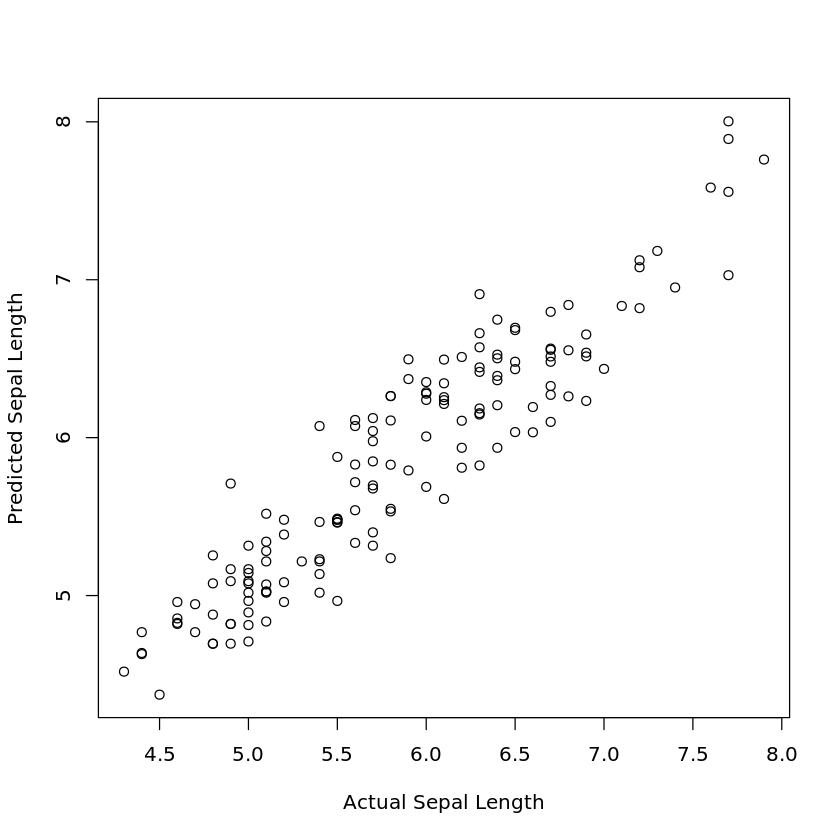

In [21]:
parsed <- jsonlite::fromJSON(result)

plot(
    iris[,"Sepal.Length"],
    as.numeric(unlist(strsplit(parsed, ","))),
    xlab="Actual Sepal Length",
    ylab="Predicted Sepal Length"
)

---
## Review And Extensions

In this notebook we demonstrated a straightforward example to train and host an R algorithm in Amazon SageMaker - allowing us to separately specify the compute infrastructure required for the training job and online inference, and so optimize costs.

Because the "SageMaker Model" is defined by the combination of the container image we built and the `model.tar.gz` archive of artifacts the training job saves to Amazon S3, the process is very flexible. We could, for example:

- Train the algorithm entirely within a notebook (or somewhere else) and use SageMaker only for deploying the inference/serving endpoint, or
- Train the algorithm on SageMaker, but then download the result from Amazon S3 to run inference in a notebook or some other environment, or
- Easily scale out our SageMaker inference capacity by increasing the number (or size) of instances specified in the endpoint configuration, and
- Build algorithms using any libraries/packages we have access to and save model parameters in whatever formats we like.

Although R is not the easiest language to build distributed applications on top of, it is possible and by adapting the script you could also utilize multiple training job instances: For example to train multiple sub-models or conduct a custom parameter search in parallel.

This core workflow example has only scratched the surface of the functionality offered by the SageMaker platform. For example:

- By modifying the training script to accept (hyper)-parameters and print accuracy metrics to the console, you could take advantage of SageMaker's efficient Bayesian [Hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) - instead of manually tuning models.
- If your use case requires generating predictions in batch, rather than deploying endpoints to query in real-time, you could instead use [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) without needing to change any model/container code.


---
## (Optional) Clean-up

Unlike training jobs which start and stop compute infrastructure for defined jobs, SageMaker endpoints are deployed with the resources you configure and remain active until switched off.

When you're finished with this notebook, please run the cell below to delete the hosted endpoint you created and prevent ongoing charges.

In [24]:
smclient$delete_endpoint(EndpointName=r_endpoint)

$ResponseMetadata
$ResponseMetadata$RequestId
[1] "c604ddad-41aa-48fb-aa16-a773c87ec302"

$ResponseMetadata$HTTPStatusCode
[1] 200

$ResponseMetadata$HTTPHeaders
$ResponseMetadata$HTTPHeaders$`x-amzn-requestid`
[1] "c604ddad-41aa-48fb-aa16-a773c87ec302"

$ResponseMetadata$HTTPHeaders$`content-type`
[1] "application/x-amz-json-1.1"

$ResponseMetadata$HTTPHeaders$`content-length`
[1] "0"

$ResponseMetadata$HTTPHeaders$date
[1] "Thu, 01 Apr 2021 00:22:21 GMT"


$ResponseMetadata$RetryAttempts
[1] 0